# Introdução

Nesta atividade vamos seguir aproximadamente o material do livro-texto da disciplina (Géron, capítulo 2), e o notebook do material de suporte do livro em https://github.com/ageron/handson-ml .

Sua missão é prever o valor mediano de imóveis em distritos residenciais da Califórnia, baseado em algumas características.

O conjunto de dados vem do censo de 1990 da Califórnia: preços hoje em dia estão radicalmente diferentes!

# Entendendo o problema

Antes de começar a trabalhar no problema, tente entender o contexto no qual o problema se insere. Por que desejamos prever os preços medianos dos imóveis? No livro, o autor menciona que neste exemplo fictício estamos desenvolvendo um preditor de preços medianos como um subsistema de um sistema de auxílio à tomada de decisão em investimentos imobiliários. 

No livro, o autor também menciona que o sistema atual da empresa usa estimativas manuais, com um erro de cerca de 15%. Um sistema de machine learning pode, potencialmente, ser mais barato, mais rápido e mais preciso!

Você consegue pensar em outros motivos?

---

**R:**

Sobre o sistema de *machine learning*:

- Não é enviesado, ele aceita a informação bruta do jeito que ela é, sem ignorar nada. Ou melhor: **o sistema é tão enviesado quanto são os dados usados para treiná-lo!**

- É consistente: não muda de opinião ao acaso.

- É reprodutível: podemos rodar o sistema daqui a $100$ anos (em um emulador de sistemas computacionais desaparecidos a um século, talvez) e ainda teremos as mesmas respostas.

- É transferível: podemos passar o sistema adiante para outro time ou outra empresa.

---

Que tipo de problema temos aqui, do ponto de vista de machine learning:

- Aprendizado supervisionado ou não-supervisionado?

- Classificação ou regressão?

---
**R:**

Trata-se de um problema de regressão, um tipo de problema de aprendizado supervisionado.

---

Agora, selecione a medida de desempenho do seu sistema de machine learning. É importante escolher a medida de performance antes de trabalhar com o problema, para que essa escolha seja idônea. Se deixarmos a escolha para mais tarde, depois de conhecer nossos dados em detalhe, pode ser que sejamos tentados a escolher a medida de performance que nos pareça mais favorável para exibir um "bom" desempenho! Isso não é ciência!

Neste problema vamos escolher a raiz quadrada do erro médio quadrático como medida de erro (RMSE - Root Mean Squared Error). Sejam $\mathbf{X}$ e $\mathbf{y}$ nossos conjuntos de testes, onde 

- $X$ contém as características dos distritos e

- $y$ contém os valores medianos de imóveis nos correspondentes distritos. 

A matriz $\mathbf{X}$ de valores das variáveis preditoras e o vetor $\mathbf{y}$ de valores dependentes são, portanto, definidos como:

$$
\mathbf{X} = \begin{bmatrix}
\mathbf{x}_1^T \\
\mathbf{x}_2^T \\
\vdots \\
\mathbf{x}_m^T
\end{bmatrix} \, \text{ e } \, 
\mathbf{y} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_m
\end{bmatrix}
$$ 

onde $\mathbf{x}_i^T = (x_{i,1}, x_{i,2}, \cdots, x_{i,n})$.

A matriz $\mathbf{X}$ é chamada de *design matrix* em estatística.

Seja também $h(\mathbf{x})$ o nosso modelo preditivo de valores medianos de imóveis, que foi obtido através de ajuste (fit) de modelo à partir das amostras de treinamento.

Então RMSE é dado por:

$$RMSE(\mathbf{X}, \mathbf{y}, h) = 
\sqrt{\frac{1}{m} \sum_{i=1}^{m}\left(h(\mathbf{x}_i) - \mathbf{y}_i\right)^{2}}$$

Pergunta: por que elevar ao quadrado? Por que aplicar a raiz quadrada?

---

**R:**

- Elevar ao quadrado é necessário para que erros de sinais opostos não se cancelem. O mesmo vale se usássemos a função módulo ao invés do quadrado, com resultados diferentes.

- Tirar a raiz quadrada é necessário para que a unidade de medida do RMSE seja a mesma unidade de medida de $y$. Por exemplo, se $y$ é medido em dólares canadenses, então queremos que o RMSE também seja dado em dólares canadenses.

Mas existe uma outra razão para elevar ao quadrado, bastante interessante, que vamos ver em detalhes na aula 06: o regressor que minimiza o valor esperado do RMSE é $h(\mathbf{x}) = \text{Média}(Y | X = \mathbf{x})$!

---

# Inicializando o código

Na maioria dos nossos trabalhos vamos usar as bibliotecas:

- Pandas: uma biblioteca para análise de dados em Python. https://pandas.pydata.org/

- NumPy: computação científica em Python. http://www.numpy.org/

- Matplotlib: para gráficos e outras visualizações

Atenção: mais adiante vamos acabar inevitavelmente misturando o uso de duas estruturas de armazenamento de dados em tabelas: DataFrames (Pandas) e ndarrays (NumPy), fique atento!

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Vamos fixar a semente do gerador de números aleatórios, para ter reproducibilidade neste notebook. 

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Carregando dados

No livro o autor descreve a necessidade da automação no processo de adquirir e armazenar dados. Isso é muito importante sim! Para simplificar o trabalho de hoje vamos pular esta etapa, e carregar diretamente o arquivo de dados fornecido pelo professor, mas recomendo a leitura e reflexão acerca do material do livro. Afinal, são dicas valiosas de quem esteve "nas trincheiras", e eu assino embaixo das dicas dele.

Por ora vamos apenas carregar o arquivo CSV:

In [5]:
HOUSING_FILE = 'housing.csv'

def load_housing_data(housing_file=HOUSING_FILE):
    return pd.read_csv(housing_file)

housing = load_housing_data()

A função retorna um DataFrame do Pandas:

In [6]:
type(housing)

pandas.core.frame.DataFrame

Um DataFrame é uma tabela com linhas e colunas nomeadas (opcionalmente), e contém vários métodos para indexação, slicing, estatísticas, e muito mais. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

# Entendendo inicialmente os dados

Cada linha da tabela representa um distrito da Califórnia. Vamos conhecer mais sobre os dados:

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.head(n=10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


Perguntas:

- Quantos distritos existem na base?

- Qual é a coluna de valores dependentes?

- Tem valor faltante?

- O que representam as colunas "total_rooms", "total_bedrooms", e "households"?

---

**R:**

- Quantos distritos existem na base?

Existem $20640$ distritos, conforme visto no resultado de ```housing.info()```

- Qual é a coluna de valores dependentes?

Os *targets*, ou valores dependentes, são os valores da coluna ```median_house_value```

- Tem valor faltante?

Sim. Podemos observar que a coluna ```total_bedrooms``` tem apenas $20433$ valores não-nulos.

- O que representam as colunas "total_rooms", "total_bedrooms", e "households"?

```households``` representa o número de residências no distrito

```total_rooms``` é o número de cômodos existentes no distrito, somando-se o número de cômodos em todas as residências deste.

```total_bedrooms``` é o número de quartos existentes no distrito, somando-se o número de quartos em todas as residências deste.

---

Para ganhar um entendimento melhor da distribuição dos dados:

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Note que a coluna "ocean_proximity" não aparece aqui, pois trata-se de uma coluna não-numérica. Apenas as colunas numéricas estão presentes, e a coluna "ocean_proximity" indica rótulos - trata-se de dados categóricos. 

Para analisar colunas com dados categóricos, podemos usar o método ``value_counts()`` na *série* associada à coluna de interesse:

In [10]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
type(housing['ocean_proximity'])

pandas.core.series.Series

Se as estatisticas descritivas sumárias do método ``describe()`` não são suficientes para se obter uma visão dos dados, tente histogramas:

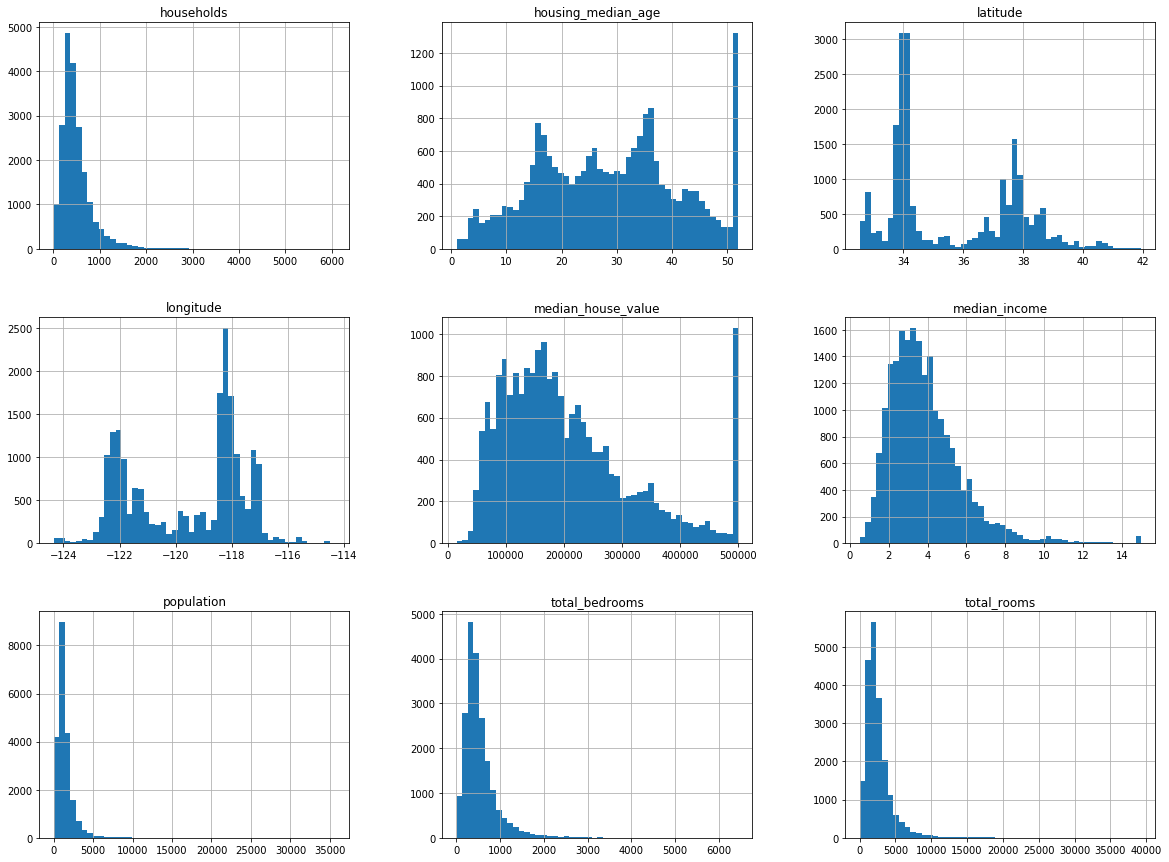

In [12]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Perguntas:

- Notou alguma anomalia? Qual? Por que você acha que isso aconteceu?

- Quais são as unidades de medida de cada coluna?

- Este dataset tem um problema sério: o preço mediano dos imóveis foi artificialmente limitado em 500k. Talvez no formulário de pesquisa de dados tivesse uma opção, na seção "Preço do imóvel", onde estava escrito "mais de 500k". Como garantir que o sistema funcionará para prever preços acima de 500k?

---

**R:**

- Notou alguma anomalia? Qual? Por que você acha que isso aconteceu?

No histograma correspondente à coluna ```housing_median_age``` temos uma raia desproporcional no extremo direito do gráfico. O mesmo acontece em relação à ```median_house_value``` e, em menor escala, ```median_income```. Estes fenômenos provavelmente se devem à *saturação*: o pesquisador definiu limites artificiais para estas variáveis, e valores que excedessem estes limites foram registrados como sendo o próprio valor limite.

- Quais são as unidades de medida de cada coluna?

| Variável            | Unidade de medida   |
|---------------------|---------------------|
| longitude           | graus               |
| latitude            | graus               |
| housing_median_age  | anos                |
| total_rooms         | contagem            |
| total_bedrooms      | contagem            |
| population          | contagem            |
| households          | contagem            |
| median_income       | x US\$10k / ano (*) |
| median_house_value  | US\$                |
| ocean_proximity     | categórica          |

\* https://www.kaggle.com/camnugent/california-housing-prices

- Este dataset tem um problema sério: o preço mediano dos imóveis foi artificialmente limitado em 500k. Talvez no formulário de pesquisa de dados tivesse uma opção, na seção "Preço do imóvel", onde estava escrito "mais de 500k". Como garantir que o sistema funcionará para prever preços acima de 500k?

Não dá para fazer milagre aqui. Ou coletamos mais dados para cobrir a faixa acima de 500k, ou nos restringimos a valores menores que 500k.


---

***PARE!***

Antes de prosseguir, devemos dividir nossos dados em duas partes: conjunto de treinamento e de testes! *E devemos jurar solenemente que jamais vamos explorar o conjunto de testes, devemos utilizá-lo apenas para as medidas finais de desempenho do nosso sistema!*

Tal medida se faz necessária para evitar overfitting, mesmo sem querer! Pode ser que observemos algum padrão nos dados de teste e incorporemos este padrão (inconscientemente) nas nossas decisões de projeto do modelo de machine learning. Então nosso resultado final será otimista demais, e nosso sistema não terá um desempenho tão bom em produção. À esse tipo de viés induzido por ter "espiado" os dados de teste chamamos ****data snooping bias****

# Dividindo os dados em conjunto de treinamento e de testes

Para selecionar um conjunto de testes, basta escolher aleatoriamente algumas amostras do conjunto original. Tipicamente selecionamos 20% da amostra para testes. Os demais pontos de dados serão o conjunto de treinamento.

Isto pode ser feito com Scikit-Learn usando a função ``train_test_split()``:

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=RANDOM_SEED)

In [14]:
print('{} train + {} test'.format(len(train_set), len(test_set)))

16512 train + 4128 test


Normalmente isso basta.

Porém, o livro tece várias considerações de natureza prática a respeito de como fazer uma boa separação entre conjuntos de treinamento e teste. Em particular:

- Separação por valor de hash: quando estamos em um ambiente onde o conjunto de dados cresce a cada dia (como no caso do autor do livro, que era do time de machine learning do YouTube), é importante ter uma política de seleção de dados de teste que não permita que itens de teste migrem para o conjunto de treinamento ao se fazer uma nova amostragem dos dados.

- Separação estratificada: quando é importante garantir representatividade proporcional aproximadamente igual nos conjuntos de treinamento e teste, em relação a algum atributo, devemos usar separação estratificada. Por exemplo: se queremos dividir um grupo de pacientes em um experimento entre conjuntos de controle e de tratamento, devemos usar separação estratificada em relação ao sexo dos participantes.

O código abaixo faz separação estratificada em relação à uma variável categórica inventada que se relaciona com a renda média:

In [15]:
# Constroi uma coluna nova com categorias de renda fictícias.
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)


# Divide, de modo estratificado, o conjunto de dados.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [17]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [18]:
# Remove a coluna nova, que foi adicionada apenas temporariamente.
strat_train_set.drop(['income_cat'], axis=1, inplace=True)
strat_test_set.drop(['income_cat'], axis=1, inplace=True)

In [19]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [20]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 10 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 non-null float64
total_rooms           4128 non-null float64
total_bedrooms        4079 non-null float64
population            4128 non-null float64
households            4128 non-null float64
median_income         4128 non-null float64
median_house_value    4128 non-null float64
ocean_proximity       4128 non-null object
dtypes: float64(9), object(1)
memory usage: 354.8+ KB


A partir de agora usaremos os conjuntos strat_train_set e strat_test_set. O conjunto strat_train_set será usado para várias explorações e para construir nosso modelo preditivo. O conjunto strat_test_set será usado só no final do projeto, para avaliar a performance final do nosso modelo.

# Explorando melhor os dados de treinamento

Nossa missão agora é construir um modelo preditivo à partir dos exemplos do conjunto de treinamento. Para isso, devemos:

- Visualizar e explorar os dados para entendê-los melhor

- Preparar os dados para machine learning

- Escolher uma boa família de modelos

- Treinar os modelos, fazer ajuste fino dos hiperparâmetros.

Para explorar os dados é recomendável que você separe um pedaço do conjunto de treinamento para explorar. O motivo é prático: fica mais rápido iterar sobre os dados, visualizar, etc! Como este dataset é minúsculo (para os padrões de machine learning), vamos explorar o conjunto de treinamento inteiro mesmo.

In [21]:
housing = strat_train_set.copy()

### Dados geográficos

Vamos visualizar os dados geográficos, para começar:

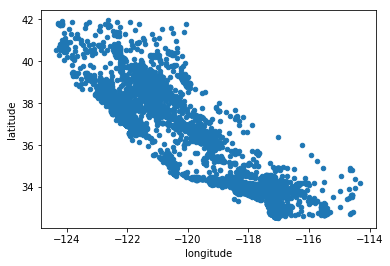

In [22]:
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

Como temos muitos dados agrupados, fica difícil distinguir a real densidade de pontos.

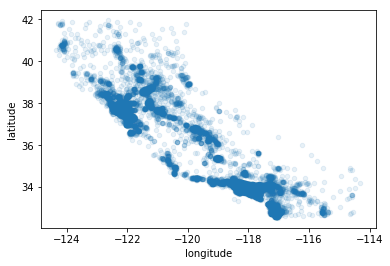

In [23]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)  # Teste vários valores de alpha.
plt.show()

Opa, agora melhorou!

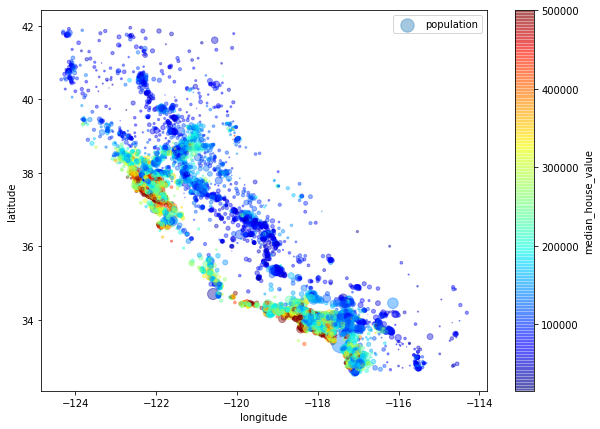

In [24]:
housing.plot(
    kind="scatter", 
    x="longitude", y="latitude", s=housing["population"]/100, 
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    label="population", figsize=(10,7), alpha=0.4,
    sharex=False)
plt.legend()
plt.show()

Muito melhor! Agora parece que a localização do distrito impacta bastante o preço mediano! Nossa intuição já dizia que esta informação era valiosa, a visualização ajuda a confirmar.

### Correlação entre variáveis

A simples correlaçao linear (correlação de Pearson, ou valor R) entre a variável dependente e cada uma das variáveis independentes já pode ser um bom indicador da chance de sucesso do nosso futuro modelo preditivo.

Já a correlação entre variáveis independentes pode indicar que temos variáveis "repetitivas" no nosso conjunto de dados, e isso pode diminuir o desempenho do nosso modelo preditivo.

Observe que estamos olhando apenas para correlação linear, o tipo mais simples de correlação. Para medir relacionamentos não-lineares, existem várias outras medidas de correlação não-linear:

- Correlação de postos (rank correlation): correlação de Spearman, correlação $\tau$ de Kendall. Ambos estão implementados no método ``corr()`` dos DataFrames do Pandas (o default é Pearson).

- Informação mútua e outras medidas de teoria da informação

- entre outras!

Trata-se de uma área fértil da estatística.

Pergunta (para casa):

- O que são as correlações de Spearman e Kendall?

---

**R:**


Ambas são correlações posicionais, que conseguem detectar dependências entre variáveis mesmo que estas não estejam relacionadas linearmente entre si.

### Coeficiente de correlação de postos de Spearman

Também conhecida como correlação de *rank*, ou de postos. É a correlação de Pearson aplicada aos postos dos itens (sua posição na lista ordenada). Por exemplo: se os dados são $\{(\mathbf{x}_i, \mathbf{y}_i)\} = \{(0, 1), (2, 6), (8, 4), (10, 9)\}$, então o coeficiente de correlação de postos de Spearman é calculado assim:

1. Transforme os pontos de dados em seus respectivos postos:

- $\mathbf{r_x} = [1, 2, 3, 4]$ pois $\mathbf{x}$ já está ordenado.

- $\mathbf{r_y} = [1, 3, 2, 4]$ pois a segunda e terceira posições estão fora de ordem.

2. Agora calcule a correlação de Pearson entre $\mathbf{r_x}$ e $\mathbf{r_y}$

$$
\overline{r_x} = \overline{r_y} = \frac{1 + 2 + 3 + 4}{4} = 2.5
$$

$$
\sigma_x = \sigma_y = \sqrt{\frac{(1 - 2.5)^2 + (2 - 2.5)^2 + (3 - 2.5)^2 + (4 - 2.5)^2}{3}} = \sqrt{\frac{5}{3}} \approx 1.291
$$

$$
\sigma_{xy} = \frac{(1 - 2.5) (1 - 2.5) + (2 - 2.5) (3 - 2.5) + (3 - 2.5) (2 - 2.5) + (4 - 2.5) (4 - 2.5)}{3} = \frac{4}{3} \approx 1.333
$$

$$
\rho_{x,y} = \frac{\sigma_{xy}}{\sigma_{x} \sigma_{y}} = 0.8
$$

### Coeficiente $\tau$ de correlação de Kendall

Se temos $n$ pontos de dados, conseguimos formar $n (n - 1) / 2$ pares. Dois pontos $(x_i, y_i)$ e $(x_j, y_j)$ concordam entre si se $(x_i - x_j)$ e $(y_i - y_j)$ tem o mesmo sinal. Quantos pares de pontos concordam entre si? Quantos discordam? A correlação $\tau$ (tau) de Kendall é a diferença entre concordantes e discordantes, dividida pelo total de pares.

Neste exemplo temos os seguintes pares:

| ponto 1 | ponto 2 | concordam? |
|---------|---------|------------|
| (0, 1)  | (2, 6)  | sim |
| (0, 1)  | (8, 4)  | sim |
| (0, 1)  | (10, 9) | sim |
| (2, 6)  | (8, 4)  | não |
| (2, 6)  | (10, 9) | sim |
| (8, 4)  | (10, 9) | sim |

Temos $5$ concordâncias e $1$ discordância, portanto $\tau = (5 - 1) / 6 \approx 0.667$

Ambas as correlações podem ser calculadas com a biblioteca Pandas conforme exemplo a seguir:

In [25]:
x = [0, 2, 8, 10]
y = [1, 6, 4, 9]
df = pd.DataFrame({"x": x, "y": y})
print(df.corr(method='pearson'))
print(df.corr(method='spearman'))
print(df.corr(method='kendall'))

          x         y
x  1.000000  0.707107
y  0.707107  1.000000
     x    y
x  1.0  0.8
y  0.8  1.0
          x         y
x  1.000000  0.666667
y  0.666667  1.000000


---

In [26]:
correlation_matrix = housing.corr()

In [27]:
correlation_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


Perguntas:

1. Observe que a diagonal da matriz de correlação contém apenas valores 1.0. Por que?

2. Explique o significado das seguintes correlações:

    2.1. "population" vs "households"
    
    2.2. "households" vs "total_rooms" e "households" vs "total_bedrooms"
    
    2.3. "median_house_value" vs "median_income"
    
    2.4. "population" vs "median_income"
    
    2.5. "latitude" vs "longitude". Seria similar no Chile? E na cidade de São Paulo? E no Brasil como um todo?

---

**R:**

1. Porque os elementos da diagonal da matriz de correlação representam a correlação de uma variável consigo mesma, que sempre vale $1.0$.

2.1 A correlação entre "population" e "households" é alta, conforme esperado: quanto maior a população, mais residências.

2.2 A correlação entre "households" e "total_rooms" é alta, assim como a correlação entre "households" e "total_bedrooms", pois quanto maior o número de residências, maior o número acumulado de cômodos e de quartos.

2.3 Esta correlação, apesar de moderada-alta, é bastante importante: representa o fato de que o preço dos imóveis em um distrito está positivamente associado com a renda de seus residentes.

2.4 A população de um distrito não está associada com a renda de seus habitantes.

2.5 Trata-se de uma correlação acidental, que reflete o fato de que a California é uma região geográfica alongada ao longo de um eixo! O mesmo fenômeno aconteceria no Chile. Na cidade de São Paulo teríamos um pouco deste fenômeno de correlação espacial alta mas não muito: o espaço da cidade de São Paulo é mais redondo que o Chile ou a California. No Brasil como um todo teríamos novamente uma correlação baixa entre latitude e longitude, posto que o Brasil não possui um território alongado. Mas se nos concentrássemos em densidade populacional, ai sim a correlação entre latitude e longitude seria alta, pois muito da população brasileira se localiza na costa do Atlântico!

---

Ok, mas o que a gente quer é saber: quais variáveis independentes podem nos ajudar a prever a variável dependente? Vamos nos concentrar na coluna "median_house_value":

In [28]:
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Em resumo: como dizemos na gíria de ciência dos dados - parece que tem sinal ai!

# Preparando os dados para o modelo

Estamos agora mais encorajados a construir um modelo de machine learning para nosso problema: nossa investigação mostrou a existência de sinal, e não apenas ruído.

Temos agora que preparar nossos dados e nosso modelo:

- Separar a variável dependente das variáveis independentes

- Resolver o problema dos valores faltantes na coluna "total_bedroom"

- A maioria dos modelos de machine learning lida com variáveis numéricas apenas. Temos que fazer algo em relação à variável categórica "ocean_proximity"

- Adicionar outras transformações: criar características extras que podem ser úteis, reescalar características, etc.

## Separando X e y

In [29]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
housing = strat_train_set.drop("median_house_value", axis=1)

# Variável dependente, também chamada de label.
housing_labels = strat_train_set["median_house_value"].copy()

## Resolvendo o problema dos valores faltantes

Como percebemos antes, estão faltando alguns valores na coluna "total_bedrooms":

In [30]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


Bom, temos 3 alternativas:

- Remover a coluna inteira de dados faltantes, ou

- Remover as linhas onde estão faltando dados, ou

- Preencher os buracos

Vamos adotar esta última estratégia. (As outras duas ficam como exercício para vocês.) Qual o valor ideal para usar aqui? Novamente, temos algumas opções:

- Preenche com zeros

- Treinar um modelo de machine learning para prever os valores desta coluna e usar o modelo para preencher os espaços! Trata-se de uma forma mais sofisticada de interpolação.

- Usar alguma estatística do dataset, como a mediana

O mais simples e realista é adotar a mediana, é o que vamos fazer então. Scikit-Learn tem uma classe especial de transformadores de dados que serve exatamente para isso, chamada ``SimpleImputer``:

In [31]:
# Cria um imputer que substitui células inválidas (NaN) pela mediana dos valores da coluna à qual a célula pertence.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Antes de treinar o SimpleImputer, remover a coluna de dados categóricos. O dataset resultante tem apenas
# as variáveis independentes numéricas.
housing_num = housing.drop("ocean_proximity", axis=1)

# Agora treinar o Imputer. Isto vai causar o cálculo da mediana de cada coluna, 
# que ficará armazenado no Imputer para uso futuro. 
imputer.fit(housing_num)

# O Imputer agora tem as estatísticas desejadas armazenadas.
print("Estatísticas do Imputer:")
print(imputer.statistics_)

# Compare com as medianas do DataFrame:
print("Medianas")
print(housing_num.median().values)

Estatísticas do Imputer:
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
Medianas
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


Agora que temos o Imputer para preencher os buracos, vamos usá-lo.

In [32]:
# Aplicar o Imputer aos nossos dados. O valor de retorno é um ndarray do NumPy.
temp = imputer.transform(housing_num)
print(type(temp))

# Trabalhar com DataFrames geralmente é mais legal - dá para referenciar colunas por nome, ao invés de indices.
# Vamos transformar o ndarray em DataFrame.
housing_tr = pd.DataFrame(temp, columns=housing_num.columns)
print(type(housing_tr))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


Verificando se os buracos foram preenchidos:

In [33]:
housing_tr[housing_tr.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


Ótimo, não tem mais buraco!

## Codificando variáveis categóricas

A maioria dos algoritmos de machine learning trabalha apenas com variáveis numéricas, mas a coluna "ocean_proximity" tem strings, representando categorias. Como proceder?

Uma forma de abordar este problema é converter as categorias em inteiros. Isto pode ser feito usando a classe ``OrdinalEncoder`` do Scikit-Learn 0.20 (o livro está desatualizado):

In [34]:
# Separar apenas as variáveis categóricas (neste caso temos apenas uma).
housing_cat = housing[["ocean_proximity"]]
print(type(housing_cat))
print(housing_cat.head())

<class 'pandas.core.frame.DataFrame'>
      ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN


In [35]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [36]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Para alguns problemas isso pode ser uma abordagem válida. Porém, na maioria dos casos isso não serve, pois gera uma hipótese implícita de que as categorias são ordenáveis, e que podemos somar e subtrair valores de categorias!

A abordagem mais comum para a codificação de variáveis categóricas é convertê-las em uma representação vetorial, onde cada dimensão corresponde a uma categoria, e os valores em cada dimensão podem valer apenas zero ou um. Mais ainda, apenas uma dimensão valerá um, as demais valem zero. À esta representação chamamos 'one-hot encoding', por analogia com o mecanismo de sinalização em circuitos elétricos no qual apenas um fio está energizado por vez (one-hot).

No nosso problema temos cinco categorias: ``'<1H OCEAN'``, ``'NEAR OCEAN'``, ``'INLAND'``, ``'NEAR BAY'`` e ``'ISLAND'``. Então vamos associar a categoria de um distrito a um vetor de dimensão 5, com valor um na dimensão correspondente à categoria do objeto, e zero no resto. 

Por exemplo, se o distrito tem categoria ``'NEAR OCEAN'``, transformamos esta informação no vetor ``(0, 1, 0, 0, 0)``. (Assumindo que as dimensões deste vetor correspondem às categorias na mesma ordem listada no parágrafo anterior.)

No Scikit-Learn, a classe ``OneHotEncoder`` recebe uma variável categórica qualquer (inteiros ou strings) e aplica a codificação *one-hot*.

In [37]:
# Cria o codificador.
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')

# Aprende a codificação e já aplica a mesma ao dataset fornecido. Todo transformador no sklearn
# tem os métodos fit() para aprender a transformação, e transform() para aplicá-la.
# O método fit_transform() faz os dois atos em sequência.
housing_cat_1hot = encoder.fit_transform(housing_cat)

# O resultado da codificação é uma matriz esparsa em NumPy.
print(housing_cat_1hot)

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 4)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 1)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 1)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 1)	1.0
  (15, 0)	1.0
  (16, 3)	1.0
  (17, 1)	1.0
  (18, 1)	1.0
  (19, 1)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 1)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 1)	1.0
  (16489, 4)	1.0
  (16490, 3)	1.0
  (16491, 0)	1.0
  (16492, 3)	1.0
  (16493, 1)	1.0
  (16494, 1)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 3)	1.0
  (16498, 1)	1.0
  (16499, 0)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 4)	1.0
  (16503, 0)	1.0
  (16504, 1)	1.0
  (16505, 1)	1.0
  (16506, 0)	1.0
  (16507, 1)	1.0
  (16508, 1)	1.0
  (16509, 1)	1.0
  (16510, 0)	1.0
  (16511, 3)	1.0


In [38]:
# Convertendo em matriz densa só para observar melhor:
print(housing_cat_1hot.toarray()[:5])

# Você poderia também ter usado sparse=False na criação do OneHotEncoder.

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [39]:
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Criando transformadores

``OneHotEncoder`` e ``SimpleImputer`` são exemplos de transformadores no Scikit-Learn: classes que podem ser treinadas para transformar dados. 

Vamos criar um transformador para adicionar as características de população-por-casa, comodos-por-casa e, opcionalmente, quartos-por-comodo.

(Nota: no livro o autor discute o uso de flags para ligar/desligar comportamentos dos transformadores, para facilitar o teste de alternativas. São palavras sábias, e um padrão muito comum de desenvolvimento de software. Vai lá ler.)

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # Column index.
    rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
    
    def __init__(self, add_bedrooms_per_room=True):  # No *args or **kwargs.
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # Nothing else to do.

    def transform(self, X, y=None):
        rooms_per_household = \
            X[:, CombinedAttributesAdder.rooms_ix] / X[:, CombinedAttributesAdder.household_ix]
        population_per_household = \
            X[:, CombinedAttributesAdder.population_ix] / X[:, CombinedAttributesAdder.household_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = \
                X[:, CombinedAttributesAdder.bedrooms_ix] / X[:, CombinedAttributesAdder.rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Transformando em DataFrame, porque DataFrames são mais amigáveis.
columns_housing_extra_attribs = list(housing.columns) + ["rooms_per_household", "population_per_household"]
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=columns_housing_extra_attribs)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


Outro transformador importante é o ``StandardScaler``. Em muitos modelos de machine learning é importante que os dados não estejam em escalas numéricas muito diferentes, nem estejam em localizações médias muito diferentes da origem. Para tanto, é comum *normalizar* os dados. Lembram de Ciência dos Dados? Quando vocês normalizavam os dados para testá-los usando a curva normal? Bem, é a mesma coisa aqui: remover a média e dividir pelo desvio padrão. 

## Pipelines

Uma pipeline é uma sequência de operações. Scikit-Learn tem uma classe dedicada à construção de pipelines, onde vários transformers podem ser encadeados em uma pipeline para se comportar como um único transformer.

Vamos construir uma pipeline para encadear as várias transformações que aplicamos aos nossos dados numéricos:

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

Note que os valores já não são os mesmos de ``housing_num``, por conta do ``StandardScaler``.

A variável categórica também merece uma "pipeline" de um estágio só agora - bear with me for now...

In [42]:
cat_pipeline = Pipeline([
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

housing_cat_tr = cat_pipeline.fit_transform(housing_cat)
housing_cat_tr

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Ao invés de aplicar nossas pipelines à variáveis ``housing_cat`` e ``housing_num``, seria interessante aplicá-las simplesmente à  ``housing``. Para isso precisamos de um transformer que:

- Faça a seleção de colunas de ``housing`` para separar as variáveis contínuas das categóricas, 
- Aplique as respectivas pipelines transformadoras e
- Junte os resultados.

Essas atividades podem ser construidas com a classe ``ColumnTransformer`` do Scikit-Learn:

In [43]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

Esta pipeline final pode ser aplicada para transformar os dados de treinamento originais em dados de treinamento processados, prontos para treinar o modelo preditivo:

In [44]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared[:5]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

Em resumo, construimos uma pipeline que:

- Codifica adequadamente as variáveis categóricas, usando one-hot encoding.
- Preenche os buracos do dataset com valores medianos, usando o Imputer.
- Adiciona novas features.
- Normaliza os dados, para evitar problemas com alguns modelos de machine learning.

**Atividade:**

Crie um notebook e "passe a limpo" o material desenvolvido até agora: copie os códigos essenciais para

- Ler os dados

- Separar de modo estratificado os dados em conjunto de treinamento e teste

- Criar a pipeline de preparação dos dados. A mesma pipeline será usada mais tarde no conjunto de testes.

---

**R:** Ver material no final deste notebook.

---

# Construindo modelos preditivos

Finalmente é chegada a hora de construir modelos preditivos! O modelo mais simples de regressão é a regressão linear, na qual desejamos estimar um valor dependente como uma combinação linear dos valores independentes (mais um termo constante).

Treinar um modelo no Scikit-Learn é simples: basta criar um regressor, e chamar o método ``fit()`` deste regressor para ajustar os parâmetros internos do modelo:

In [45]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Vamos selecionar alguns pontos de dados para demonstrar o funcionamento do nosso regressor:

In [46]:
# Seleciona 5 pontos do conjunto de treinamento.
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

# Prepara os dados - não se esqueça deste passo.
some_data_prepared = full_pipeline.transform(some_data)

# Para obter as previsões, basta chamar o método predict()
predicted_labels = lin_reg.predict(some_data_prepared)
print("Predição: {}".format(predicted_labels))

# Compare com os valores originais:
print("Original: {}".format(some_labels.values))

Predição: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Original: [286600. 340600. 196900.  46300. 254500.]


Parece que está funcionando, aproximadamente!

Pergunta: por que é muito otimista dizer que as coisas estão funcionando bem agora?

---

**R:**

Porque estamos realizando a previsão de valores que foram empregados no conjunto de treinamento - estamos prevendo algo já visto.

---

Vamos medir o erro de predição no conjunto de treinamento:

In [47]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 68628.20


E se a gente trocasse de regressor? Vamos tentar aplicar uma árvore de decisão. Primeiro, treinar o modelo:

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

Agora, medir o erro do modelo:

In [49]:
predicted_labels = tree_reg.predict(some_data_prepared)
print("Predição: {}".format(predicted_labels))
print("Original: {}".format(some_labels.values))

Predição: [286600. 340600. 196900.  46300. 254500.]
Original: [286600. 340600. 196900.  46300. 254500.]


Opa, meio suspeito isso! Vamos ver o erro total:

In [50]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('Regressão linear: RMSE = {:.2f}'.format(tree_rmse))

Regressão linear: RMSE = 0.00


Bem, parece que achamos o regressor perfeito! Na verdade, já vimos esse fenômeno antes...

Pergunta: o que aconteceu aqui?

---

**R:**

Novamente, o problema é que estamos realizando a previsão em cima de um dado já visto no conjunto de treinamento. O fato de que o $\text{RMSE} = 0.0$ no conjunto de treinamento muito provavelmente é um forte indicador de *overfitting*, ou seja, o classificador se ajustou com perfeição aos dados de treinamento e isto é ruim: significa que o classificador "aprendeu" até mesmo o erro amostral dos dados de treinamento.

---

# Melhorando nossa avaliação usando validação cruzada

Vamos lembrar onde estamos neste processo: nossa tarefa no momento é:

- Escolher uma família de modelos de machine learning que seja adequada ao nosso problema

- Escolher os melhores parâmetros e hiperparâmetros para nosso modelo

Para escolher um bom modelo, temos que tentar estimar o erro de teste do modelo. Por que não simplesmente usar o conjunto de testes aqui? Porque *só vamos tocar no conjunto de testes DEPOIS QUE TODAS AS DECISÕES JÁ TENHAM SIDO TOMADAS!*

Então tudo o que temos é o conjunto de treinamento. E gostaríamos de treinar nosso modelo em um certo conjunto de dados, e testá-lo em outro conjunto de dados. Como resolver esse dilema?

Simples: vamos novamente dividir o conjunto de treinamento em dois! Usamos um pedaço para treinar modelos, e outro para testar desempenho. À esta validação de modelos usando apenas o conjunto de treinamento chamamos ***validação cruzada***.

Por simplicidade vamos usar divisão não-estratificada, e vamos dividir diretamente o dataset pós-pipeline.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(housing_prepared, housing_labels, test_size=0.2, random_state=RANDOM_SEED)

In [52]:
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão árvore de decisão: RMSE = {:.2f}'.format(lin_rmse))

Regressão árvore de decisão: RMSE = 69392.52


In [53]:
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão linear: RMSE = {:.2f}'.format(tree_rmse))

Regressão linear: RMSE = 71023.94


Agora faz mais sentido! Tanto o regressor linear quanto o regressor de árvore de decisão tem desempenho similar! Vamos tentar mais um regressor, desta vez um regressor poderoso chamado Random Forest:

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

In [55]:
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 50405.12


Parece que o random forest é melhor que os outros!

Mas talvez todos esses resultados sejam pura sorte: como saber? Podemos repetir esses experimentos com partições diferentes e ver se o resultado se mantém. O scikit-learn já tem ferramentas para ajudar nessa tarefa:

In [56]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print("Scores (ordenados): [{}]".format(" ".join(["{:.2f}".format(x) for x in sorted(scores)])))
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

Scores (ordenados): [64969.63 66782.74 66960.12 67665.10 68031.13 68281.61 70347.95 71193.84 71552.92 74739.57]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


O código acima executa ***n-fold cross validation*** (neste caso, $n=10$). A função ``cross_val_score`` divide o conjunto de treinamento em $n$ partes e executa o procedimento de testes (treinar modelo, prever, medir erro) $n$ vezes - uma para cada partição. A cada ensaio a partição da vez é separada como conjunto de teste, e as demais compõe o conjunto de treinamento.

Uma vantagem desta abordagem é que agora podemos ver a faixa de desempenhos do modelo.

Vamos repetir esta atividade para os outros regressores:

In [57]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores (ordenados): [66855.16 70194.34 70262.86 70273.63 70758.74 71115.88 71231.66 72432.58 75366.88 75585.14]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [58]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores (ordenados): [47461.91 47585.74 48634.80 49308.39 49519.80 50021.59 50029.03 52325.28 53446.38 53490.11]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


Agora sim podemos dizer, com segurança, que o regressor random forest é melhor que os outros!

Pergunta: Podemos mesmo dizer isso? Como cientista de dados, como você responderia essa questão com mais segurança?

---

**R:**

Como cientista de dados, temos que traduzir a pergunta "Será que *Random Forests* é melhor que os outros modelos?" em uma **hipótese testável**. Para isso vamos construir um **teste de hipótese**.

**Nossos dados**: Múltiplos valores de $\text{RMSE}$ para cada regressor.

**Nossa pergunta**: "Será que o desempenho médio (ou seja, $\overline{\text{RMSE}}$) do *Random Forests* é superior ao desempenho médio dos demais modelos de regressão?"

**Nossos testes de hipótese**:

Vamos chamar de $\mu_{\text{RF}}$, $\mu_{\text{DT}}$ e $\mu_{\text{LR}}$ a média populacional do $\text{RMSE}$ dos modelos *Random Forests*, *Decision Tree* e *Linear Regressor* respectivamente. 

*Teste #1*: Comparar *Random Forests* com *Decision Tree*.

*Hipótese nula* $H_0$: $\mu_{\text{RF}} = \mu_{\text{DT}}$

*Hipótese alternativa* $H_1$: $\mu_{\text{RF}} \neq \mu_{\text{DT}}$

Aqui temos duas alternativas: podemos realizar um **teste paramétrico** ou um **teste não-paramétrico**

### Teste paramétrico

- Neste caso vamos supor que as variáveis aleatórias  $\text{RMSE}_{\text{RF}}$ e $\text{RMSE}_{\text{DT}}$ seguem alguma distribuição conhecida (e.g. distribuição normal).

- Vamos então pensar quais seriam as distribuições de  $\mu_{\text{RF}}$ e $\mu_{\text{DT}}$ a partir dos nossos dados, para então chegar à uma conclusão sobre a distribuição da diferença $\mu_{\text{RF}} - \mu_{\text{DT}}$. Por exemplo, se $\text{RMSE}_{\text{RF}}$ e $\text{RMSE}_{\text{DT}}$ tem distribuição normal então $\overline{\text{RMSE}}_{\text{RF}}$ (que é o estimador de $\mu_{\text{RF}}$) e $\overline{\text{RMSE}}_{\text{DT}}$ (que é o estimador de $\mu_{\text{DT}}$) seguem distribuições $t$, e o mesmo vale para a sua diferença.

- Com essa distribuição da diferença de médias, podemos calcular nossa estatística de teste. Neste caso será a estatística $t$.

- Por fim, podemos obter o **valor-p** da estatística obtida, e comparar com o **nível de significância** $\alpha$ que desejamos usar em nosso estudo. Valores típicos de $\alpha$ são $0.05$ ($5 \%$), $0.01$ ($1 \%$) ou $0.001$ ($0.1 \%$). Vamos vem em qual faixa de valores nosso valor-p se encaixa. Queremos que, no mínimo, o valor-p seja inferior ao valor $\alpha = 0.05$.

Este teste está implementado no pacote ``scipy.stats``, na função ``ttest_ind`` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html):


In [59]:
from scipy.stats import ttest_ind

def compara_scores(scores_1, scores_2):
    t_stat, p_value = ttest_ind(scores_1, scores_2, equal_var=False)
    print("Valor da estatística t: {:.2f}".format(t_stat))
    print("Valor-p: {}".format(p_value))

compara_scores(forest_rmse_scores, tree_rmse_scores)

Valor da estatística t: -19.79
Valor-p: 1.7922655912039697e-13


Como o *p-value* é muito baixo, podemos dizer **com significância estatística** $\alpha = 0.001$ que *Random Forests* é melhor que *Decision Tree*.

Vamos aplicar o mesmo teste para comparar *Random Forests* e *Linear Regressor*, e também *Decision Tree* com *Linear Regressor*:

In [60]:
compara_scores(forest_rmse_scores, lin_rmse_scores)

Valor da estatística t: -16.44
Valor-p: 8.119243743158793e-12


In [61]:
compara_scores(tree_rmse_scores, lin_rmse_scores)

Valor da estatística t: 1.93
Valor-p: 0.0698196090807132


Podemos concluir que o *Random Forests* também é superior ao *Linear Regressor*. Já a comparação entre *Linear Regressor* e *Decision Tree* é inconclusiva, pois o valor-p obtido é maior que o nível de significância adotado (lembra? queríamos que no mínimo $\alpha = 0.05$ fosse satisfeito).

### Teste não paramétrico

O problema com o teste paramétrico é que temos que supor que os dados originais seguem alguma distribuição dada, e que essa distribuição é alguma daquelas distribuições comportadas (normal, etc) para que possamos derivar por completo os resultados do teste de hipótese. Quando não se deseja impor uma distribuição aos dados originais, podemos usar um teste não-paramétrico.

Para comparar dois conjuntos de amostras e verificar se estes tem a mesma média podemos construir um **teste de permutação**.

#### Teste de permutação

Considere duas amostras de valores, representados abaixo por quadradinhos azuis e verdes (o valor não nos importa nesta explicação, somente a lógica a ser seguida):

![Ilustração teste permutação](perm_orig.png "Teste de permutação: configuração original")

A lógica do teste de permutação é a seguinte: 

- Suponha que as duas amostras vieram de distribuições com a mesma média (possivelmente a mesma distribuição, possivelmente diferentes).

- Então a diferença de médias entre a primeira amostra e a segunda (ou seja, $m_1 - m_2$) deveria ser uma variável aleatória com média zero.

- **Vamos reamostrar a diferença de médias artificialmente**:

    - Misture as duas amostras, recalcule a diferença de médias
    
    - Repita várias vezes, quanto mais melhor

![Ilustração teste permutação](perm_perm.png "Teste de permutação: configuração permutada")

- Com as amostras artificiais da diferença de médias, determine o percentil em que se encontra a diferença de médias original. Com este percentil podemos obter um valor-p não paramétrico para a diferença de médias.

Vamos construir uma função que realiza o teste de permutação:

In [62]:
from scipy.stats import percentileofscore

def permutation_test(sample_1, sample_2, n_permutations=100):
    diff_orig = np.mean(sample_1)- np.mean(sample_2)
    n1 = len(sample_1)

    # Junta as amostras em um grande array unificado.
    pooled_samples = np.concatenate((sample_1, sample_2))

    diffs = []
    for i in range(n_permutations):
        # Embaralha o grande array unificado e separa duas amostras fake.
        np.random.shuffle(pooled_samples)
        m1 = np.mean(pooled_samples[:n1])
        m2 = np.mean(pooled_samples[n1:])
        
        # Guarda a diferença de médias.
        diffs.append(m1 - m2)

    # Determina o percentil em que se localizava a diferença de médias original.
    q = percentileofscore(diffs, diff_orig) / 100.0
    if q < 0.5:
        pvalue = 2*q
    else:
        pvalue = 2*(1 - q)
        
    return pvalue

Vamos testar esse código. Primeiro, vamos testar com amostras extraídas da mesma distribuição estatística:

In [63]:
np.random.seed(RANDOM_SEED)

sample_1 = np.random.normal(loc=42, scale=1, size=20)
sample_2 = np.random.normal(loc=42, scale=1, size=10)

permutation_test(sample_1, sample_2)

0.8799999999999999

Agora vamos testar o caso em que as amostras foram obtidas de distribuições com médias diferentes: 

In [64]:
sample_1 = np.random.normal(loc=42, scale=1, size=20)
sample_2 = np.random.normal(loc=43, scale=1, size=10)

permutation_test(sample_1, sample_2)

0.02

Note que o valor-p é muito menor quando existe uma diferença real entre as médias das distribuições originais das amostras. Vamos testar então a performance de nossos regressores:

In [65]:
# Random Forests versus Decision Tree.
print(permutation_test(forest_rmse_scores, tree_rmse_scores))

# Random Forests versus Linear Regressor.
print(permutation_test(forest_rmse_scores, lin_rmse_scores))

# Decision Tree versus Linear Regressor.
print(permutation_test(tree_rmse_scores, lin_rmse_scores))

0.0
0.0
0.06000000000000005


Com este resultado temos que o algoritmo *Random Forests* é significativamente (no sentido estatístico) superior à *Decision Tree* e ao regressor linear neste problema! Vemos também que nada se pode afirmar na comparação entre árvore de decisão e regressor linear.

#### Teste U de Mann-Whitney

Outra forma de comparar os nossos regressores é perguntar: se eu treinar um regressor *Random Forests* e uma árvore de decisão, qual a probabilidade de que o desempenho do *Random Forests* seja melhor? Esta pergunta é respondida pelo teste U de Mann-Whitney. A letra "U" vem de *"unbiased"* (não-enviesado), e diz respeito a toda uma categoria de estatísticas não-paramétricas.

Matematicamente, estamos perguntando o seguinte: se $X$ é a variável aleatória (V.A.) dos valores do grupo 1, e $Y$ a V.A. do grupo 2, qual o valor de $P(X < Y)$?

Podemos calcular este valor com a estatística U de Mann-Whitney que é computada como se fosse um grande torneio de xadrez entre os grupos 1 (com $n_1$ amostras) e 2 (com $n_2$ amostras):

- Construa todos os pares $(x,y)$ onde $x$ veio do grupo 1 e $y$ do grupo 2.

- Contabilize $1$ ponto para o grupo 1 se $x > y$, ou 1 ponto para o grupo 2 se $y > x$. Em caso de empate, ambos os grupos recebem $0.5$ ponto. 

A pontuação final de cada grupo é o valor da estatística de teste U de Mann-Whitney para cada grupo.

Se os dois grupos vem de distribuições com a mesma **mediana**, podemos esperar que o valor da estatística de teste será balanceado entre os grupos e deve valer metade do número total de disputas, ou seja, $n_1 n_2 / 2$. Mais ainda, esperamos que a estatística U de Mann-Whitney para grupos com mesma mediana deverá seguir aproximadamente (para valores grandes de $n_1$ e $n_2$ uma curva normal:

$$
U_1 \sim N\left(\mu_U = \frac{n_1 n_2}{2}, \sigma_U = \sqrt{\frac{n_1 n_2 (n_1 + n_2 + 1)}{12}}\right)
$$

A formula acima vale se não existirem empates, senão uma fórmula corrigida deve ser aplicada (https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test).

Com essa distribuição esperada para a estatística U, podemos obter o valor-p da comparação de medianas neste teste. O pacote ``scipy.stats`` implementa este teste na função ``mannwhitneyu``:

In [66]:
from scipy.stats import mannwhitneyu

# Random Forest versus Decision Tree.
U, pvalue = mannwhitneyu(forest_rmse_scores, tree_rmse_scores)
print("p-value Random Forest versus Decision Tree: {}".format(pvalue))

# Random Forest versus Linear Regressor.
U, pvalue = mannwhitneyu(forest_rmse_scores, lin_rmse_scores)
print("p-value Random Forest versus Linear Regressor: {}".format(pvalue))

# Decision Tree versus Linear Regressor.
U, pvalue = mannwhitneyu(tree_rmse_scores, lin_rmse_scores)
print("p-value Decision Tree versus Linear Regressor: {}".format(pvalue))

p-value Random Forest versus Decision Tree: 9.133589555477501e-05
p-value Random Forest versus Linear Regressor: 9.133589555477501e-05
p-value Decision Tree versus Linear Regressor: 0.06061225150645831


Novamente, podemos ver que o Random Forest é estatisticamente superior ao Decision Tree e Linear Regressor, enquanto nada se pode afirmar da diferença entre estes dois últimos.

---

# Ajuste de hiperparâmetros

Mas afinal, o que é um modelo de regressão? É uma função que transforma os dados de entrada em um valor de saída, e que também pode depender de alguns **parâmetros**:

$$y = h(x; \theta)$$

Treinar o modelo é ajustar os parâmetros do modelo para maximizar o desempenho preditivo deste. Para tanto devemos usar um algoritmo de treinamento. Cada classe de modelos demanda seu próprio algoritmo de treinamento, vamos estudar isso em detalhes mais tarde.

$$\theta_{opt} = \text{argmin}_{\theta} \{ \text{RMSE}\left(X_{\text{train}}, y_{\text{train}}, h_{\theta} \right) \}$$

Plot twist: os algoritmos de treinamento em si *também* tem seus parâmetros! Ademais, os modelos tem parâmetros que especificam sub-classes de modelos, e diferem dos parâmetros voltados ao "ajuste fino". A esses meta-parâmetros chamamos **hiperparâmetros**.

Os parâmetros regulares são ajustados pelo método ``fit()`` dos regressores. Como ajustar os hiperparâmetros? A abordagem mais simples é testar vários valores e ver o que funciona! Existem abordagens mais sofisticadas, que discutiremos depois, mas por hoje vamos testar uma dessas abordagens "força-bruta" chamada *grid search*.

Funciona assim: escolha alguns valores possíveis de hiperparâmetros, e teste todas as combinações. Vamos aplicar isso ao regressor random forest. Não se preocupe com o significado destes hiperparâmetros por enquanto, vamos estudar isso em detalhes depois.

Em scikit-learn, temos uma classe ``GridSearchCV`` para fazer isso. *AVISO*: vai demorar!

In [67]:
from sklearn.model_selection import GridSearchCV
from timeit import default_timer

param_grid = [
    # try 6 (2×3) combinations of hyperparameters
    {'n_estimators': [10, 30], 'max_features': [4, 6, 8]},
    # then try 4 (1x2×2) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

# train across 5 folds, that's a total of (6+4)*5=50 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

t1 = default_timer()
grid_search.fit(housing_prepared, housing_labels)
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')

Tempo gasto: 43.19 s


O procedimento procurou a melhor combinação de hiperparâmetros para o nosso regressor:

In [68]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

Dica: se os melhores hiperparâmetros forem o limite superior da faixa de valores testados, talvez valha a pena aumentar a faixa de pesquisa!

Pergunta: neste nosso caso valeria a pena refinar a faixa de pesquisa?

---

**R**:

Sim. Se o melhor conjunto de parametros atinge a borda da região de busca, quem sabe se a gente expandisse a região de busca não conseguiríamos melhores resultados?

---

O ``GridSearch`` já retorna o melhor modelo treinado:

In [69]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Para ver como o ``GridSearch`` achou a melhor solução, podemos ver o histórico de desempenhos testados!

In [70]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
57490.612956065226 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
51009.51445842374 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


# Importância das características

Para alguns modelos de machine learning podemos obter a importância relativa das características no processo de predição. Esta informação é importante para entender melhor nosso problema. De fato, um dos usos bastante importantes do machine learning é exatamente isso: usar o machine learning para entender melhor o problema em si!

In [71]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

Para saber quem-é-quem:

In [72]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

Parece que nossa intuição de adicionar as features extras foi acertada: estas novas features são mais importantes do que os dados brutos originais!

# Finalmente: medir o desempenho final!

O que fizemos até agora, após a preparação de dados?

- Usamos validação cruzada para achar a melhor família de regressores para nosso modelo. Note que nesta etapa não ajustamos hiperparâmetros, apenas confiamos nos valores default.

- Usamos novamente validação cruzada para achar os melhores hiperparâmetros, com busca no espaço de hiperparâmetros.

Agora temos o nosso melhor modelo, treinado na forja da validação cruzada! Chegou finalmente a hora de medir o desempenho do regressor no conjunto de testes!

In [73]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("RMSE = {}".format(final_rmse))

RMSE = 47730.22690385927


**Atividade:** Vá para o seu outro notebook e continue "passando a limpo" esta atividade. Transporte os processos essenciais de treinamento para o novo notebook, e a avaliação final de desempenho.

---

Vamos passar a limpo o notebook inteiro então.

In [74]:
%reset -f
%matplotlib inline

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from joblib import dump
from scipy.stats import mannwhitneyu
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from timeit import default_timer

RANDOM_SEED = 42
HOUSING_FILE = 'housing.csv'

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # Column index.
    rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
    
    def __init__(self, add_bedrooms_per_room=True):  # No *args or **kwargs.
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # Nothing else to do.

    def transform(self, X, y=None):
        rooms_per_household = \
            X[:, CombinedAttributesAdder.rooms_ix] / X[:, CombinedAttributesAdder.household_ix]
        population_per_household = \
            X[:, CombinedAttributesAdder.population_ix] / X[:, CombinedAttributesAdder.household_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = \
                X[:, CombinedAttributesAdder.bedrooms_ix] / X[:, CombinedAttributesAdder.rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

def display_scores(scores):
    print("Scores (ordenados): [{}]".format(" ".join(["{:.2f}".format(x) for x in sorted(scores)])))
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

np.random.seed(RANDOM_SEED)

### Leitura dos dados

Vamos ler os dados brutos e, a título de experimento, vamos remover aquelas amostras estranhas que a análise exploratória revelou:

- casas muito antigas

- casas muito caras

- rendas muito altas

In [76]:
# Leitura dos dados brutos.
housing = pd.read_csv(HOUSING_FILE)

# Manter apenas os exemplos válidos segundo a análise exploratória.
housing = housing[(housing["median_house_value"] < 500000) &
                  (housing["housing_median_age"] < 50) &
                  (housing["median_income"] < 14)]

### Pré-processamento dos dados

Vamos aplicar os passos de pré-processamento dos dados ao conjunto completo. Aqui temos uma polêmica: tanto o ``SimpleImputer`` quanto o ``StandardScaler`` são objetos treináveis, e teoricamente deveriam fazer parte da pipeline treinável (que contém o regressor em si)! Mas como não esperamos que a partição dos exemplos de treinamento e teste influenciem muito estes transformadores, estamos justificados em transportar este pedaço da pipeline para a fase de pré-processamento. Com isso ganhamos bastante tempo de processamento.

In [77]:
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"].copy()

# Construção da pipeline de processamento de atributos quantitativos.
num_attribs = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income'
]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# Construção da pipeline de processamento de atributos qualitativos. 
# Nem precisávamos fazer uma pipeline de um transformador só aqui, isso foi 
# feito apenas por motivos didáticos.
cat_attribs = ["ocean_proximity"]

cat_pipeline = Pipeline([
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

# Construção da pipeline completa.
data_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

# Por fim, aplicar a pipeline completa aos dados e separar os conjuntos de treinamento e teste.
X = data_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

### Seleção de modelo.

Vamos testar o regressor linear, a árvore de decisão e o algoritmo *Random Forests*. Vamos usar um ``GridSearchCV`` para otimizar os hiperparâmetros da *Random Forest*. Por fim vamos comparar os três modelos usando o teste U de Mann-Whitney.

In [78]:
# Procurar os melhores parâmetros para a Random Forest.
grid_search = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1),
    {'n_estimators': [300, 1000, 3000]},
    cv=4, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

t1 = default_timer()
grid_search.fit(X_train, y_train)
t2 = default_timer()
print(f'Tempo gasto: {t2 - t1:.2f} s')

# Vamos adotar o melhor regressor, ou seja, o RandomForestRegressor com os melhores hiperparâmetros.
forest_reg = grid_search.best_estimator_

# Agora vamos medir o desempenho deste regressor com validação cruzada.
t1 = default_timer()
forest_reg_scores = cross_val_score(forest_reg, X_train, y_train, 
                                    scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
t2 = default_timer()
print(f'Tempo gasto: {t2 - t1:.2f} s')

forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)
print(forest_reg_rmse_scores)

Tempo gasto: 781.25 s
Tempo gasto: 375.41 s
[44997.80737483 43665.07544098 46299.820098   45928.1545519
 42735.21932981 43599.37065756 41328.58290437 41268.26869746]


In [79]:
forest_reg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [80]:
grid_search.best_params_

{'n_estimators': 1000}

In [81]:
# Treinar a Decision Tree.
tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)

t1 = default_timer()
tree_reg_scores = cross_val_score(tree_reg, X_train, y_train, 
                                  scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
t2 = default_timer()
print(f'Tempo gasto: {t2 - t1:.2f} s')

tree_reg_rmse_scores = np.sqrt(-tree_reg_scores)
print(tree_reg_rmse_scores)

Tempo gasto: 0.94 s
[62798.59050174 62344.33931734 63072.61565073 63531.02620533
 61697.9582501  62452.96824535 61792.97566438 58441.89836258]


In [82]:
# Treinar a LinearRegression.
lin_reg = LinearRegression()

t1 = default_timer()
lin_reg_scores = cross_val_score(lin_reg, X_train, y_train, 
                                 scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
t2 = default_timer()
print(f'Tempo gasto: {t2 - t1:.2f} s')

lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)
print(lin_reg_rmse_scores)

Tempo gasto: 0.23 s
[58019.69942226 57599.52120993 59984.62660643 60649.06011721
 55501.49842419 57880.99306227 55598.52483137 55174.92197426]


In [83]:
# Comparação usando o teste U de Mann-Whitney.

# Random Forest versus Decision Tree.
U, pvalue = mannwhitneyu(forest_reg_rmse_scores, tree_reg_rmse_scores)
print("p-value Random Forest versus Decision Tree: {}".format(pvalue))

# Random Forest versus Linear Regressor.
U, pvalue = mannwhitneyu(forest_reg_rmse_scores, lin_reg_rmse_scores)
print("p-value Random Forest versus Linear Regressor: {}".format(pvalue))

# Decision Tree versus Linear Regressor.
U, pvalue = mannwhitneyu(tree_reg_rmse_scores, lin_reg_rmse_scores)
print("p-value Decision Tree versus Linear Regressor: {}".format(pvalue))

p-value Random Forest versus Decision Tree: 0.00046955284955859495
p-value Random Forest versus Linear Regressor: 0.00046955284955859495
p-value Decision Tree versus Linear Regressor: 0.0009737637929733326


### Avaliação final de desempenho.

Agora que escolhemos o regressor ideal, vamos treiná-lo com o conjunto de treinamento completo e avaliar o desempenho no conjunto de teste.

In [84]:
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

44995.41581024547


### Treinamento final

Vamos treinar o modelo com os dados completos.

In [85]:
forest_reg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Agora podemos gravar o resultado no disco. Você pode carregar esse modelo para usos futuros.

Porém, depois de todo esse esforço, você descobre que o modelo final tem aproximadamente $1.5$ GB! Isso mostra a diferença entre um modelo teoricamente bom e um modelo prático - o que adianta ganhar algumas poucas frações de desempenho se o seu objetivo era embarcar o modelo em um celular ou browser, ou rodar em escala?

In [86]:
# A proxima linha grava o modelo no disco. Cuidado: o arquivo gerado tem aproximadamente 1.5 GB
# dump(forest_reg, 'forest_reg.joblib')

# Conclusão

Você acaba de terminar um projeto completo de regressão, onde fizemos o seguinte:

- Carregamos os dados

    - Se o dataset fosse muito grande, teríamos selecionado um subset pequeno para exploração.

- Separamos os dados em conjunto de treinamento e teste.

- Visualizar e explorar os dados para entendê-los melhor

- Preparar os dados para machine learning

- Escolher uma boa família de modelos

- Treinar os modelos, fazer ajuste fino dos hiperparâmetros.

- Testar desempenho no conjunto de testes

Você aprendeu várias coisas valiosas sobre o dataset ("A renda mediana é o melhor preditor de valores de imóveis"), estimou o desempenho do seu modelo, e está pronto para implementar seu modelo em um sistema de produção! Agora é hora de montar uma boa apresentação sobre os seus resultados para o cliente (ou o chefe).

**Atividade:** Agora, chame seu professor e apresente oralmente os resultados obtidos. Esteja pronto para defender seu trabalho, e para indicar linhas de ação futuras!